# Classification Benchmarking

**The goal of this notebook is to benchmark different algorithms on the classification of the toy dataset, before moving to the next stage that is using them for our real data on the autistic project.**


The algorithms that will be tested are:

* The baseline algorithm is the use of `imputations` techniques (let's say MICE, or Matias' technic) both at training and for the inference.

    
* Imputation using Matias' `mixed_imputations` method, that resorts on pdf estimation with kernel. The model is a k dimensional distribution, estimating using a gaussian kernel with optimal bandwidth, handling missing coordinates by imputing them based on the proximity with other data from the training set. The inference for a sample is performed on the subset of coordinates that are known, by computing first the marginal of the k-dimensional distribution on the known axis. Note here that no imputation are performed at inference time, but there are during training. 
        
* The `no_imputations` approach will be used, which consist in estimating several distributions, $f_{X|Z}$, and doing inference using them. No imputation are performed, and the marginals are not used (yet). 
    
* The use of `neural_additive_models` developed in [1] will be tested. This method present an interpretable way of using neural network in this setting.
    
* The use of `XGBoost` will be tested. 



Also, direct use of the $Z$ distributions will be used for classification, usinf 

<ins>Inputs:</ins>

* $(X_n)_n \in \mathbb{R}^K$


* $(Z_n)_n \in [ 0, 1]^K $


<ins>Outputs:</ins>

* $(Y_n)_n \in [ 0, 1]$

We would like to show:

* Do a benchmarking of the different methods

    
    
<ins>Takeaways:</ins>

    * Handling missing data is better than discarding them.
    * ...

[1]. Agarwal, R. et al. Neural Additive Models: Interpretable Machine Learning with Neural Nets. Arxiv (2020).

In [4]:
run init.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done.


# Introduction - Dataset definition

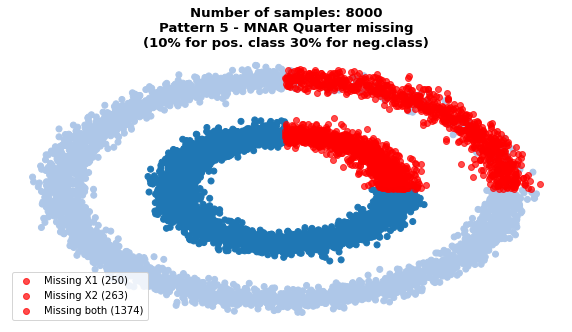

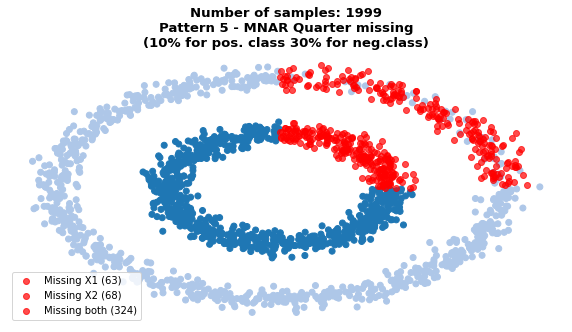

In [37]:
# Dataset default parameters
dataset_name = DATASET_NAME
num_samples = NUM_SAMPLES
imbalance_ratio = IMBALANCE_RATIO

# Missingness default parameters
missingness_pattern = MISSINGNESS_PATTERN
ratio_of_missing_values = RATIO_OF_MISSING_VALUES

# pdf estimation default parameters
resolution = RESOLUTION
bandwidth = BANDWIDTH

# Classification default parameters
proportion_train = PROPORTION_TRAIN

verbosity=1

# Dataset default parameters
dataset_name = DATASET_NAME
num_samples = NUM_SAMPLES
imbalance_ratio = IMBALANCE_RATIO

# Missingness default parameters
missingness_pattern = 5#MISSINGNESS_PATTERN
ratio_of_missing_values = RATIO_OF_MISSING_VALUES

# pdf estimation default parameters
resolution = RESOLUTION
bandwidth = BANDWIDTH

# Classification default parameters
proportion_train = PROPORTION_TRAIN



verbosity=0

# Definition of the Train and Test datasets
proportion_train  = .8


dataset_train = DatasetGenerator(dataset_name=dataset_name, 
                                purpose='train',
                                num_samples=int(proportion_train*num_samples), 
                                imbalance_ratio=imbalance_ratio, 
                                verbosity=verbosity)

dataset_test = DatasetGenerator(dataset_name=dataset_name, 
                                purpose='test',
                                num_samples=int((1-proportion_train)*num_samples), 
                                imbalance_ratio=imbalance_ratio, 
                                verbosity=verbosity)


# Creation of the missingness
dataset_train.generate_missing_coordinates(missingness_pattern=missingness_pattern, verbosity=verbosity)
dataset_test.generate_missing_coordinates(missingness_pattern=missingness_pattern, verbosity=verbosity)

dataset_train.plot(title=True)
dataset_test.plot(title=True)

# Get the data
X_test, y_test = dataset_test.get_data()
X_train, y_train = dataset_train.get_data()

# Experiment 1) `no_imputations` approach

Experiment 143 loaded successfully! :-)


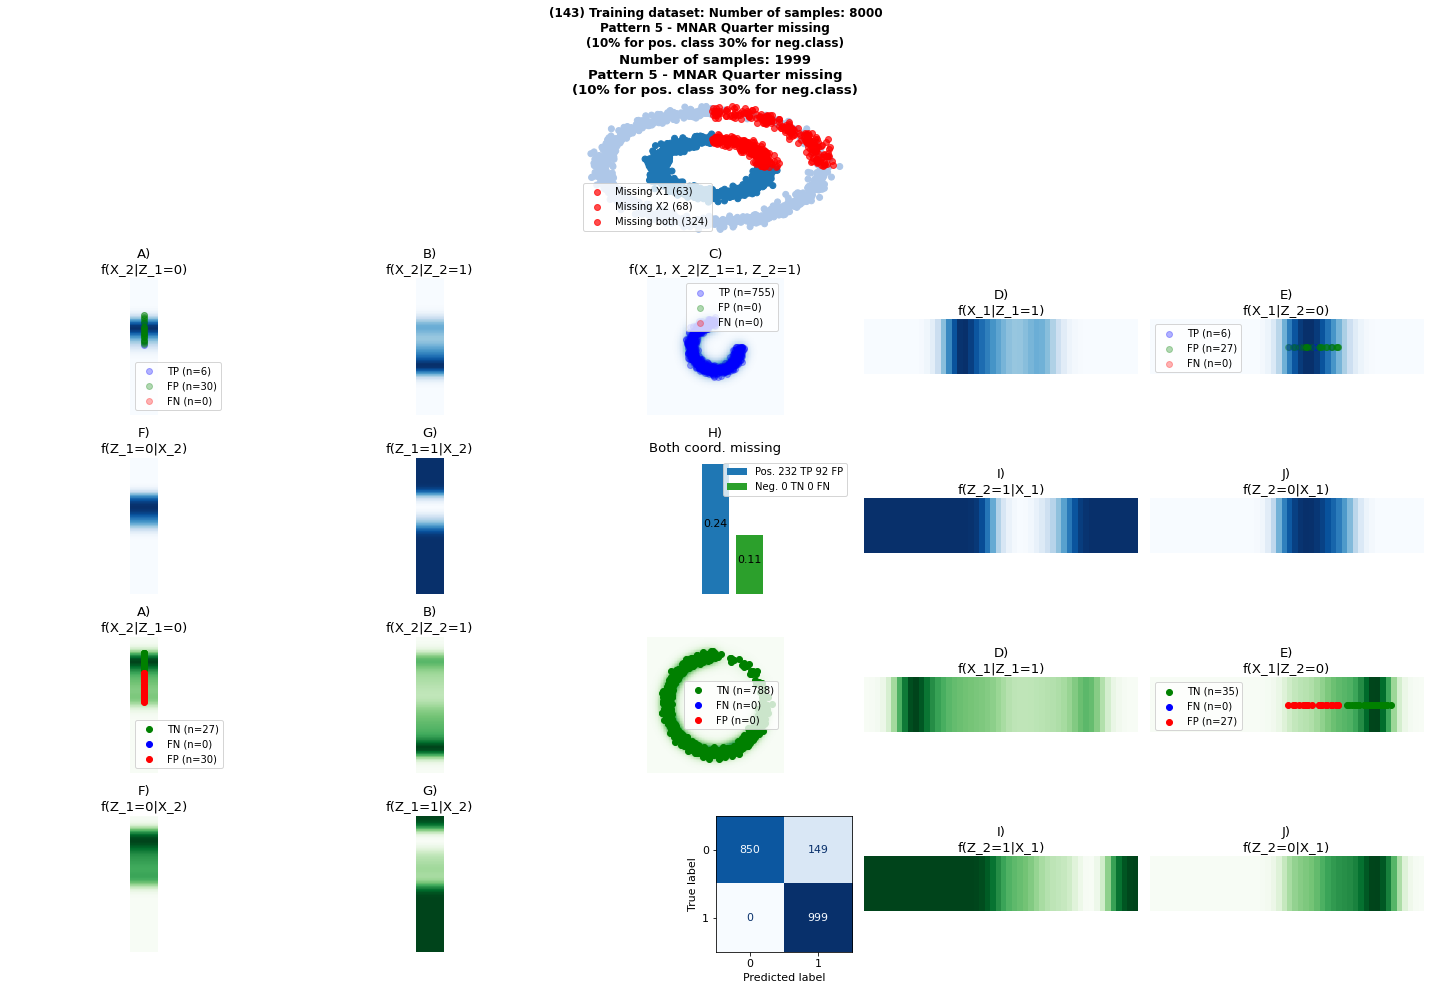

Sample: 999 positive and 999 negative samples (#p/#n=100%)



,0
Accuracy,0.925
F1 score (2 PPVxTPR/(PPV+TPR)),0.931
Matthews correlation coefficient (MCC),0.860
"Sensitivity, recall, hit rate, or true positive rate (TPR)",1.000
"Specificity, selectivity or true negative rate (TNR)",0.851
Precision or positive predictive value (PPV),0.870
Negative predictive value (NPV),1.000
Miss rate or false negative rate (FNR),0.000
False discovery rate (FDR=1-PPV),0.130
False omission rate (FOR=1-NPV),0.000


In [33]:
# Create the experiments
exp = Experiments(dataset_name, 
                  dataset_train=dataset_train, 
                  dataset_test=dataset_test, 
                  purpose='classification', 
                  previous_experiment=143, 
                  save_experiment=True, 
                  verbosity=1, 
                  debug=False, 
                  proportion_train=PROPORTION_TRAIN, 
                  resolution=RESOLUTION, 
                  bandwidth=BANDWIDTH,
                  random_state=RANDOM_STATE)


# Estimate the distributions 
#exp.fit()

# Estimate the distributions 
#exp.predict()

# Plot results
exp.plot()

Experiment 2 loaded successfully! :-)


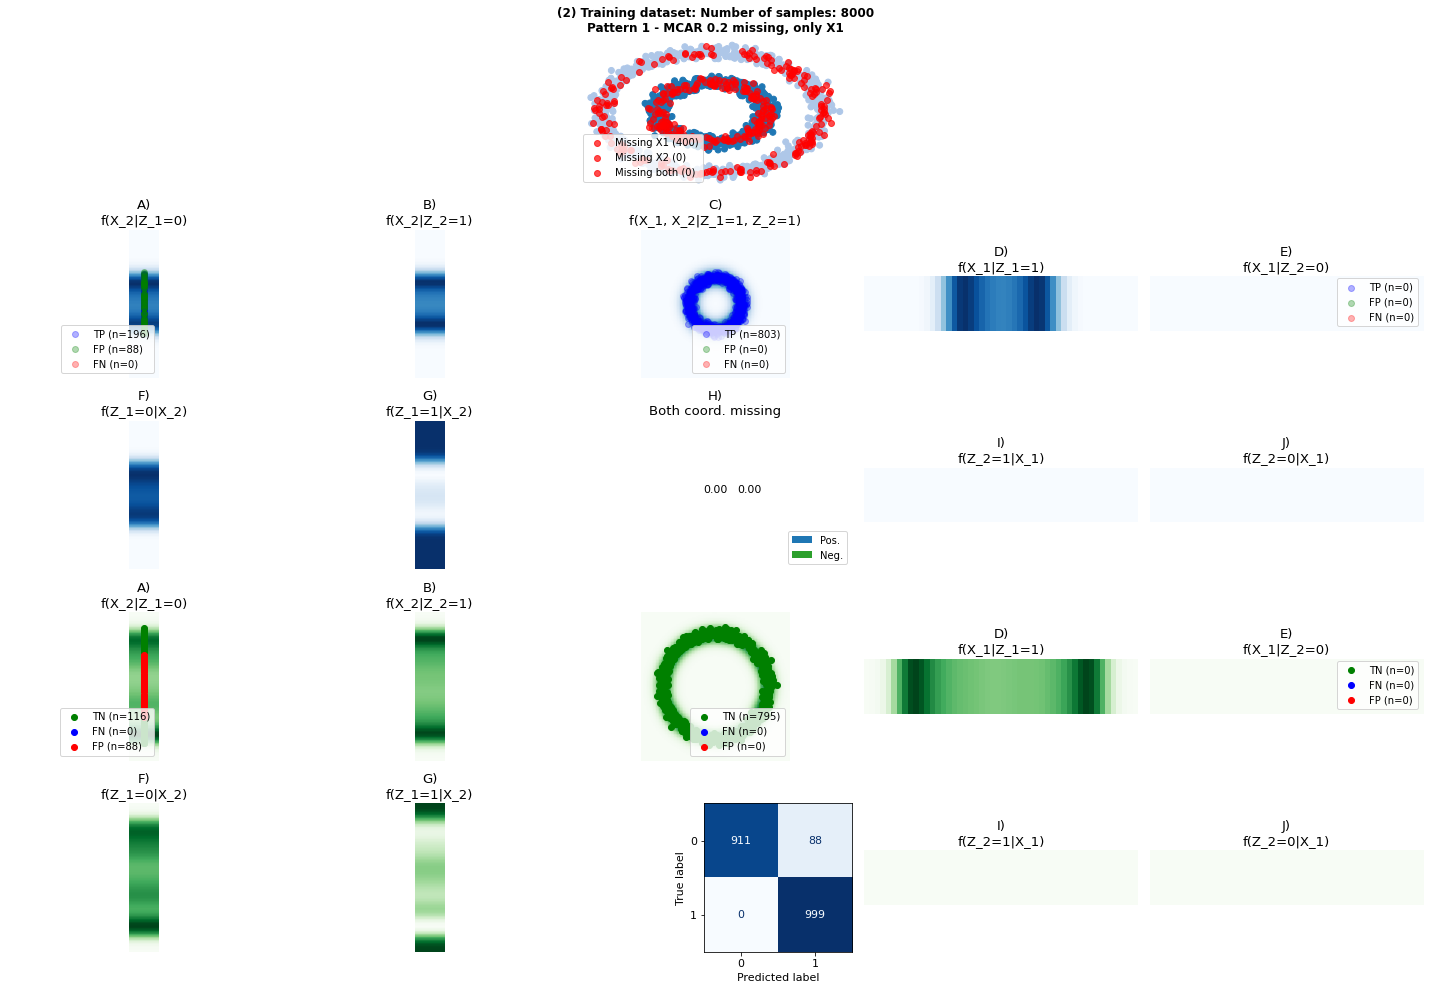

Sample: 999 positive and 999 negative samples (#p/#n=100%)



,0
Accuracy,0.956
F1 score (2 PPVxTPR/(PPV+TPR)),0.958
Matthews correlation coefficient (MCC),0.915
"Sensitivity, recall, hit rate, or true positive rate (TPR)",1.000
"Specificity, selectivity or true negative rate (TNR)",0.912
Precision or positive predictive value (PPV),0.919
Negative predictive value (NPV),1.000
Miss rate or false negative rate (FNR),0.000
False discovery rate (FDR=1-PPV),0.081
False omission rate (FOR=1-NPV),0.000


In [6]:
random_experiment = df[df['dataset_name']==dataset_name]['experiment_number'].sample(1).iloc[0].astype(int)
print("Loading experiment {}".format(random_experiment))

# Create the experiments
exp = Experiments(dataset_name, 
                  dataset_train=None, 
                  dataset_test=None, 
                  purpose='classification', 
                  previous_experiment=random_experiment, 
                  save_experiment=True, 
                  verbosity=1, 
                  debug=False, 
                  proportion_train=PROPORTION_TRAIN, 
                  resolution=RESOLUTION, 
                  bandwidth=BANDWIDTH,
                  random_state=RANDOM_STATE)

# Plot results
exp.plot()

Loading experiment 4
Experiment 4 loaded successfully! :-)


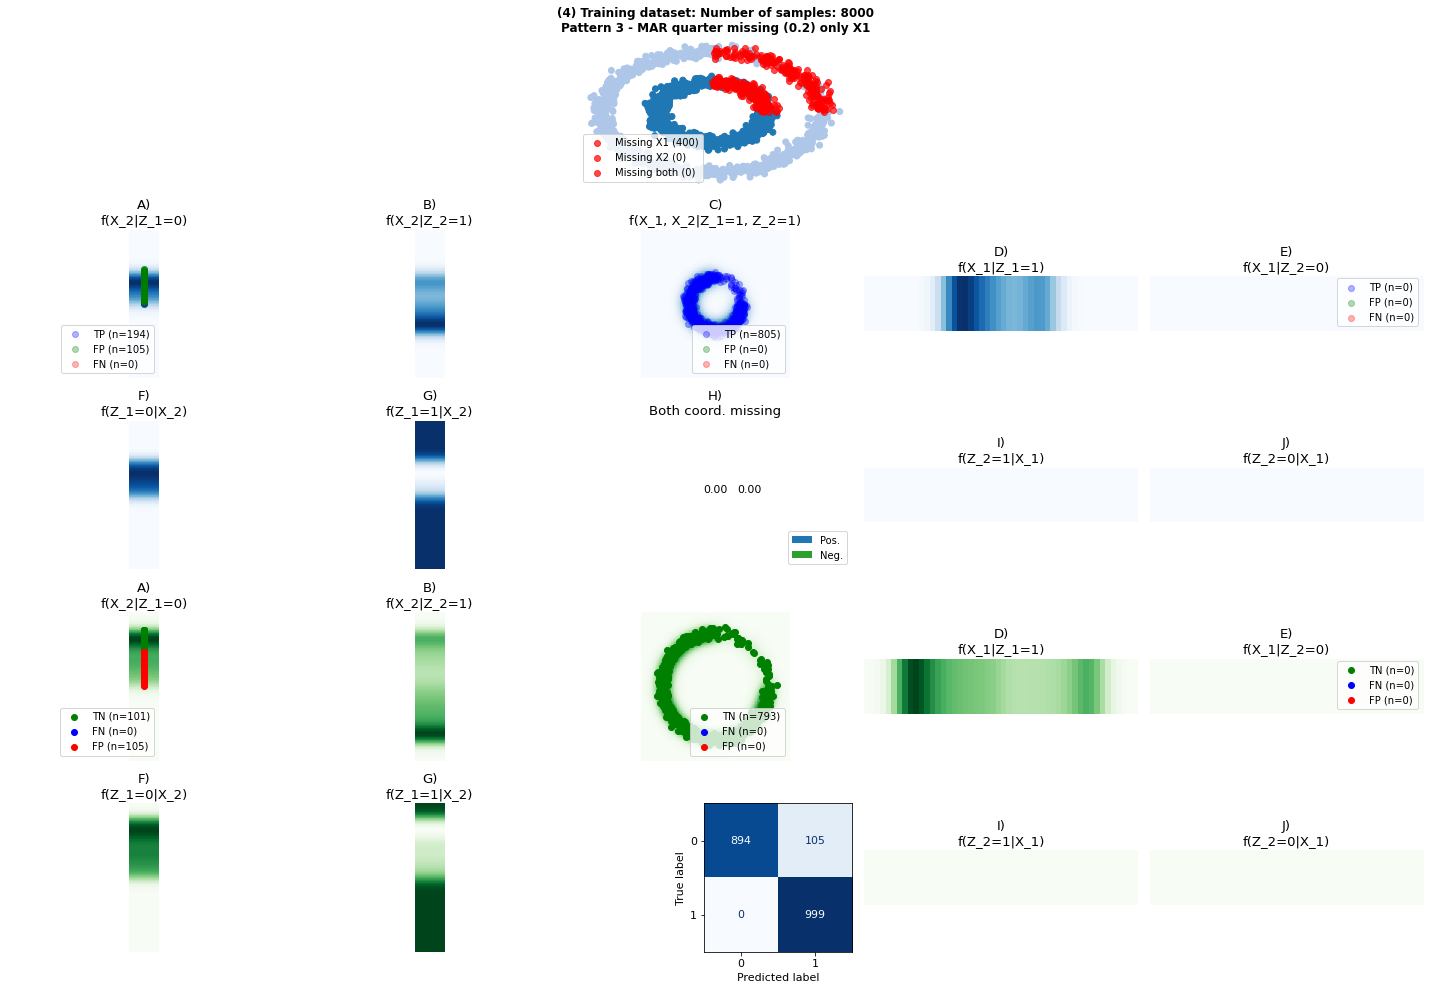

Sample: 999 positive and 999 negative samples (#p/#n=100%)



,0
Accuracy,0.947
F1 score (2 PPVxTPR/(PPV+TPR)),0.950
Matthews correlation coefficient (MCC),0.900
"Sensitivity, recall, hit rate, or true positive rate (TPR)",1.000
"Specificity, selectivity or true negative rate (TNR)",0.895
Precision or positive predictive value (PPV),0.905
Negative predictive value (NPV),1.000
Miss rate or false negative rate (FNR),0.000
False discovery rate (FDR=1-PPV),0.095
False omission rate (FOR=1-NPV),0.000


In [26]:

random_experiment = df[df['dataset_name']==dataset_name]['experiment_number'].sample(1).iloc[0].astype(int)
print("Loading experiment {}".format(random_experiment))

# Create the experiments
exp = Experiments(dataset_name, 
                  dataset_train=None, 
                  dataset_test=None, 
                  purpose='classification', 
                  previous_experiment=random_experiment, 
                  save_experiment=True, 
                  verbosity=1, 
                  debug=True, 
                  proportion_train=PROPORTION_TRAIN, 
                  resolution=RESOLUTION, 
                  bandwidth=BANDWIDTH,
                  random_state=RANDOM_STATE)

# Plot results
exp.plot()

Loading experiment 4
Experiment 34 loaded successfully! :-)


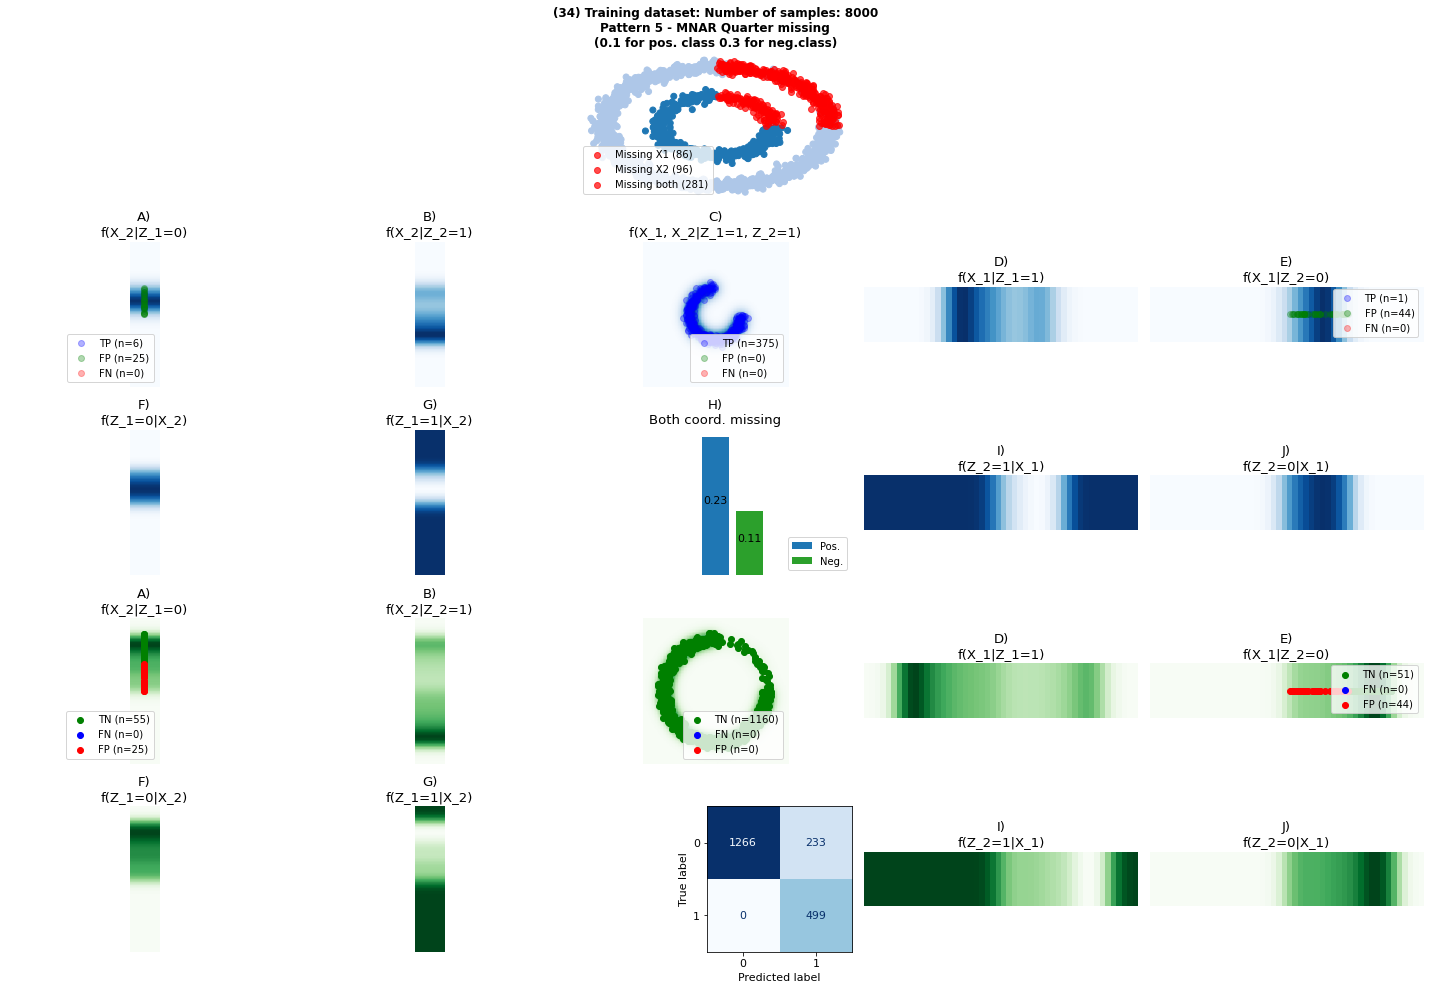

Sample: 499 positive and 1499 negative samples (#p/#n= 33%)



,0
Accuracy,0.883
F1 score (2 PPVxTPR/(PPV+TPR)),0.811
Matthews correlation coefficient (MCC),0.759
"Sensitivity, recall, hit rate, or true positive rate (TPR)",1.000
"Specificity, selectivity or true negative rate (TNR)",0.845
Precision or positive predictive value (PPV),0.682
Negative predictive value (NPV),1.000
Miss rate or false negative rate (FNR),0.000
False discovery rate (FDR=1-PPV),0.318
False omission rate (FOR=1-NPV),0.000


In [56]:
dataset_name = 'circles'

random_experiment = df[df['dataset_name']==dataset_name]['experiment_number'].sample(1).iloc[0].astype(int)
print("Loading experiment {}".format(random_experiment))

# Create the experiments
exp = Experiments(dataset_name, 
                  dataset_train=None, 
                  dataset_test=None, 
                  purpose='classification', 
                  previous_experiment=34, 
                  save_experiment=True, 
                  verbosity=1, 
                  debug=True, 
                  proportion_train=PROPORTION_TRAIN, 
                  resolution=RESOLUTION, 
                  bandwidth=BANDWIDTH,
                  random_state=RANDOM_STATE)

# Plot results
exp.plot()

Loading experiment 39
Experiment 39 loaded successfully! :-)


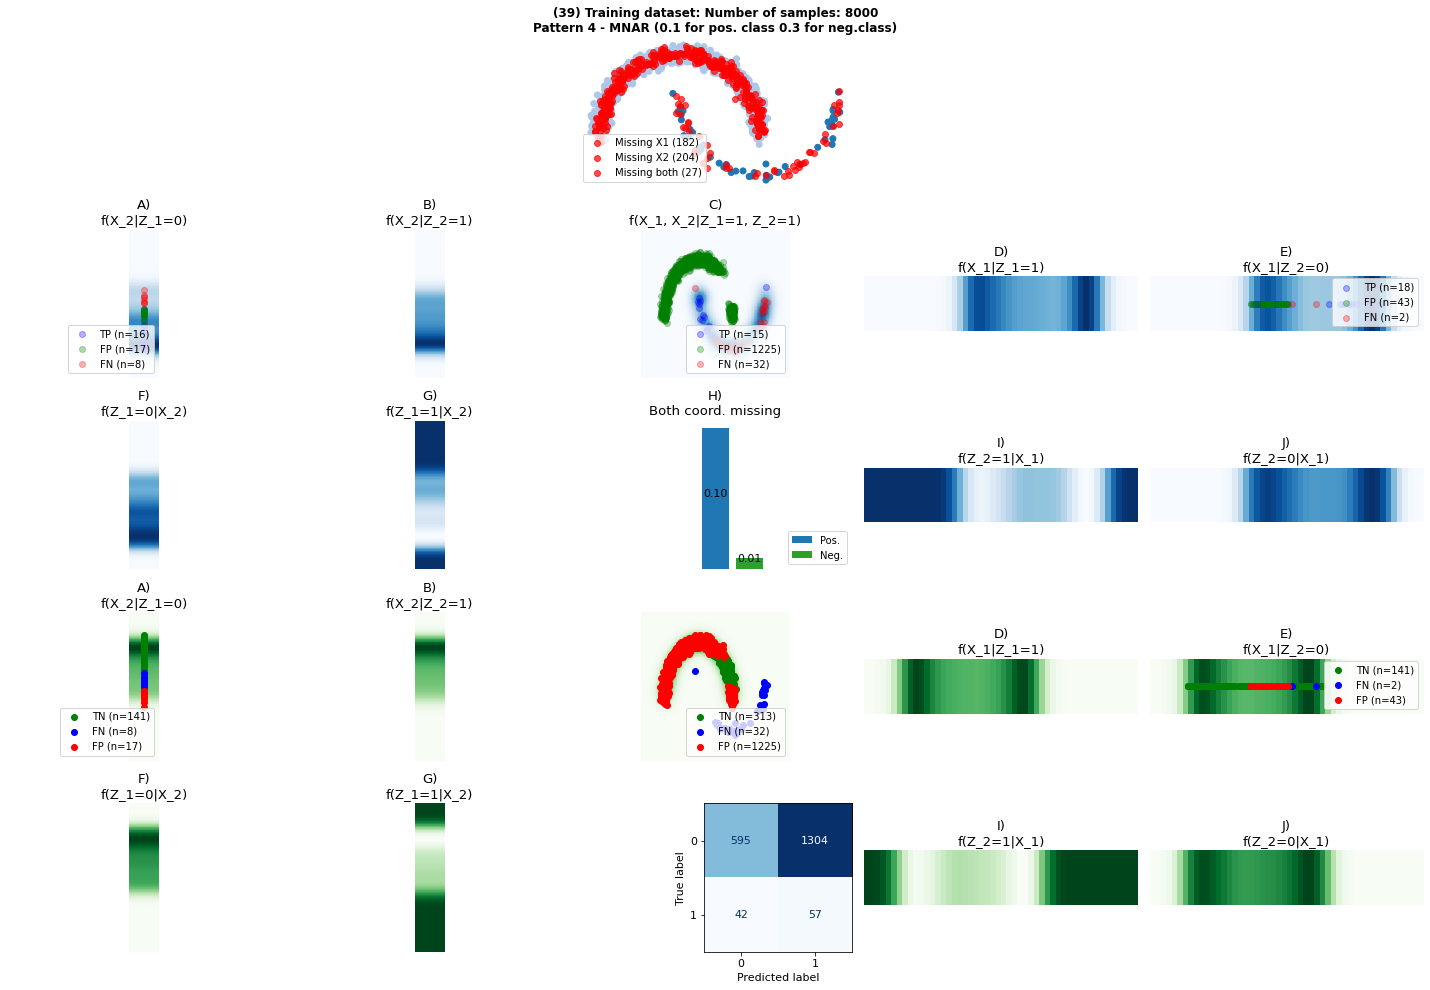

Sample: 99 positive and 1899 negative samples (#p/#n=  5%)



,0
Accuracy,0.326
F1 score (2 PPVxTPR/(PPV+TPR)),0.078
Matthews correlation coefficient (MCC),-0.052
"Sensitivity, recall, hit rate, or true positive rate (TPR)",0.576
"Specificity, selectivity or true negative rate (TNR)",0.313
Precision or positive predictive value (PPV),0.042
Negative predictive value (NPV),0.934
Miss rate or false negative rate (FNR),0.424
False discovery rate (FDR=1-PPV),0.958
False omission rate (FOR=1-NPV),0.066


In [28]:
dataset_name = 'moons'

random_experiment = df[df['dataset_name']==dataset_name]['experiment_number'].sample(1).iloc[0].astype(int)
print("Loading experiment {}".format(random_experiment))

# Create the experiments
exp = Experiments(dataset_name, 
                  dataset_train=None, 
                  dataset_test=None, 
                  purpose='classification', 
                  previous_experiment=random_experiment, 
                  save_experiment=True, 
                  verbosity=1, 
                  debug=True, 
                  proportion_train=PROPORTION_TRAIN, 
                  resolution=RESOLUTION, 
                  bandwidth=BANDWIDTH,
                  random_state=RANDOM_STATE)

# Plot results
exp.plot()

Loading experiment 75
Experiment 75 loaded successfully! :-)


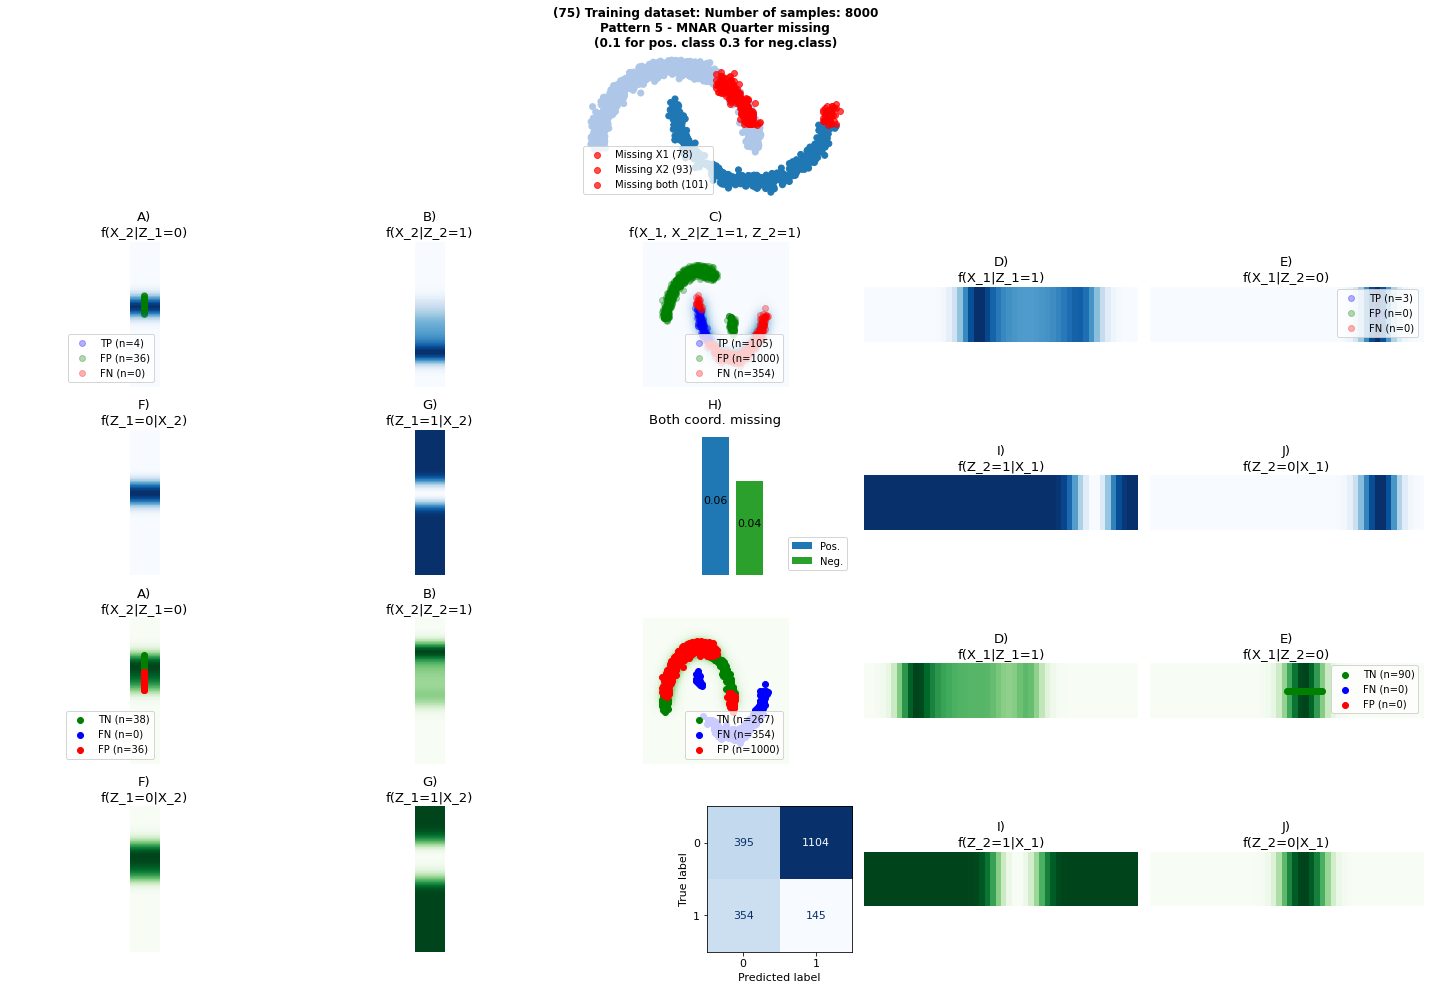

Sample: 499 positive and 1499 negative samples (#p/#n= 33%)



,0
Accuracy,0.270
F1 score (2 PPVxTPR/(PPV+TPR)),0.166
Matthews correlation coefficient (MCC),-0.399
"Sensitivity, recall, hit rate, or true positive rate (TPR)",0.291
"Specificity, selectivity or true negative rate (TNR)",0.264
Precision or positive predictive value (PPV),0.116
Negative predictive value (NPV),0.527
Miss rate or false negative rate (FNR),0.709
False discovery rate (FDR=1-PPV),0.884
False omission rate (FOR=1-NPV),0.473


In [40]:
dataset_name = 'moons'

random_experiment = df[df['dataset_name']==dataset_name]['experiment_number'].sample(1).iloc[0].astype(int)
print("Loading experiment {}".format(random_experiment))

# Create the experiments
exp = Experiments(dataset_name, 
                  dataset_train=None, 
                  dataset_test=None, 
                  purpose='classification', 
                  previous_experiment=random_experiment, 
                  save_experiment=True, 
                  verbosity=1, 
                  debug=True, 
                  proportion_train=PROPORTION_TRAIN, 
                  resolution=RESOLUTION, 
                  bandwidth=BANDWIDTH,
                  random_state=RANDOM_STATE)

# Plot results
exp.plot()

Experiment 45 loaded successfully! :-)


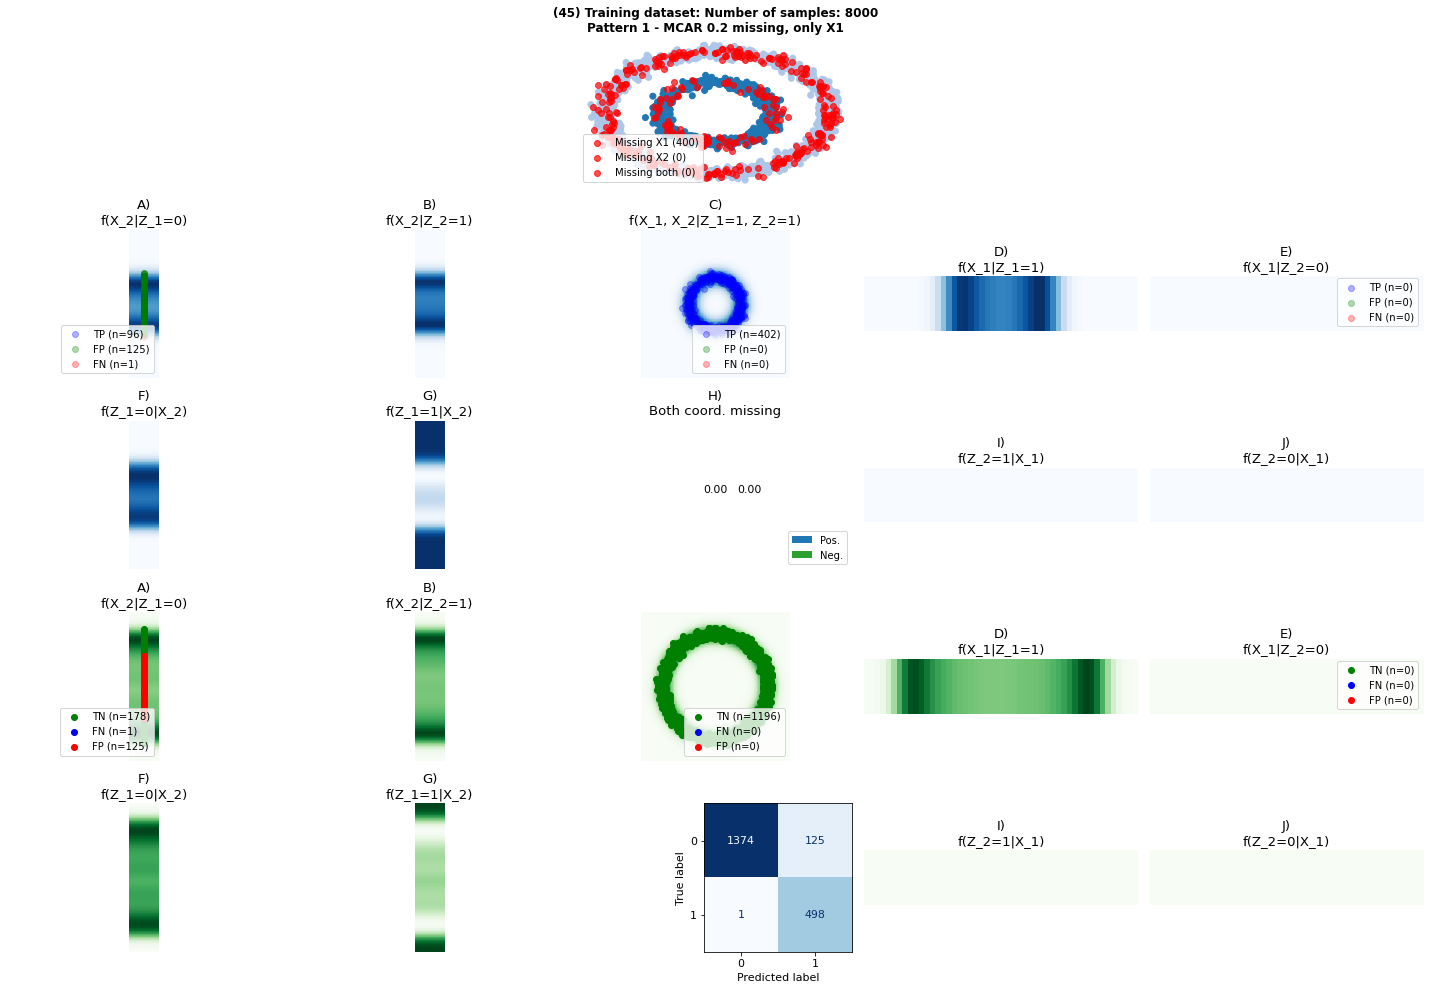

Sample: 499 positive and 1499 negative samples (#p/#n= 33%)



,0
Accuracy,0.937
F1 score (2 PPVxTPR/(PPV+TPR)),0.888
Matthews correlation coefficient (MCC),0.855
"Sensitivity, recall, hit rate, or true positive rate (TPR)",0.998
"Specificity, selectivity or true negative rate (TNR)",0.917
Precision or positive predictive value (PPV),0.799
Negative predictive value (NPV),0.999
Miss rate or false negative rate (FNR),0.002
False discovery rate (FDR=1-PPV),0.201
False omission rate (FOR=1-NPV),0.001


In [29]:
random_experiment = df[df['dataset_name']==dataset_name]['experiment_number'].sample(1).iloc[0].astype(int)
#print("Loading experiment {}".format(random_experiment))

# Create the experiments
exp = Experiments(dataset_name, 
                  dataset_train=None, 
                  dataset_test=None, 
                  purpose='classification', 
                  previous_experiment=45,#random_experiment, 
                  save_experiment=True, 
                  verbosity=1, 
                  debug=False, 
                  proportion_train=PROPORTION_TRAIN, 
                  resolution=RESOLUTION, 
                  bandwidth=BANDWIDTH,
                  random_state=RANDOM_STATE)

# Plot results
exp.plot()

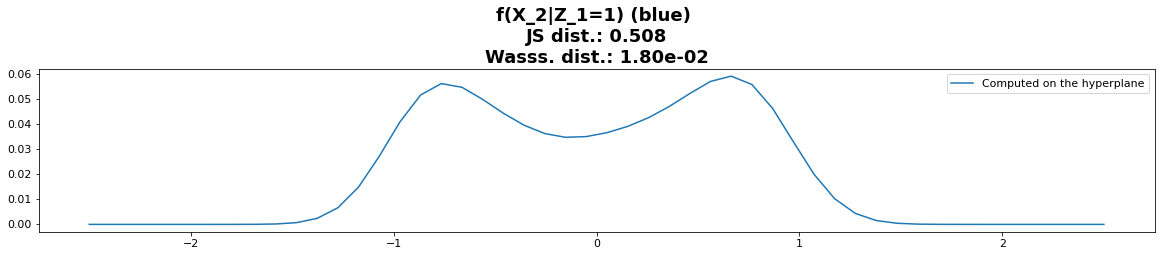

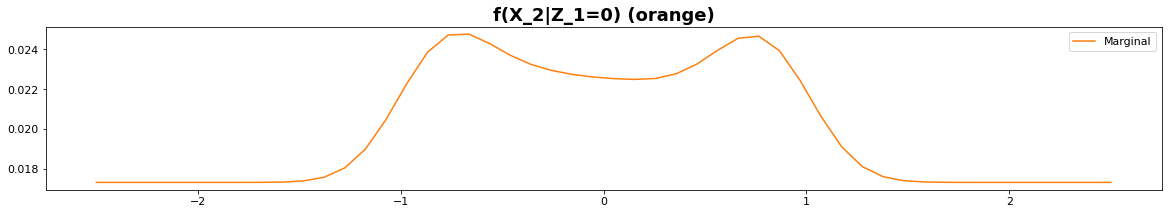

In [31]:
from scipy.spatial import distance
from scipy.stats import wasserstein_distance
fi(20, 3)
plt.plot(np.linspace(-2.5,2.5, exp.resolution), exp.dist_pos.f_2, color='tab:blue',label='Computed on the hyperplane')
plt.title("f(X_2|Z_1=1) (blue) \nJS dist.: {:.3f}\nWasss. dist.: {:.2e}".format(distance.jensenshannon(exp.dist_pos.f_2, exp.dist_pos.f_2_marginal, 2.0), wasserstein_distance(exp.dist_pos.f_2, exp.dist_pos.f_2_marginal)), weight='bold', fontsize=18)
plt.legend()

fi(20, 3)
plt.plot(np.linspace(-2.5,2.5, exp.resolution), exp.dist_pos.f_2_marginal, color='tab:orange', label='Marginal')
plt.title("f(X_2|Z_1=0) (orange)", weight='bold', fontsize=18)
plt.legend()


Experiment 44 loaded successfully! :-)


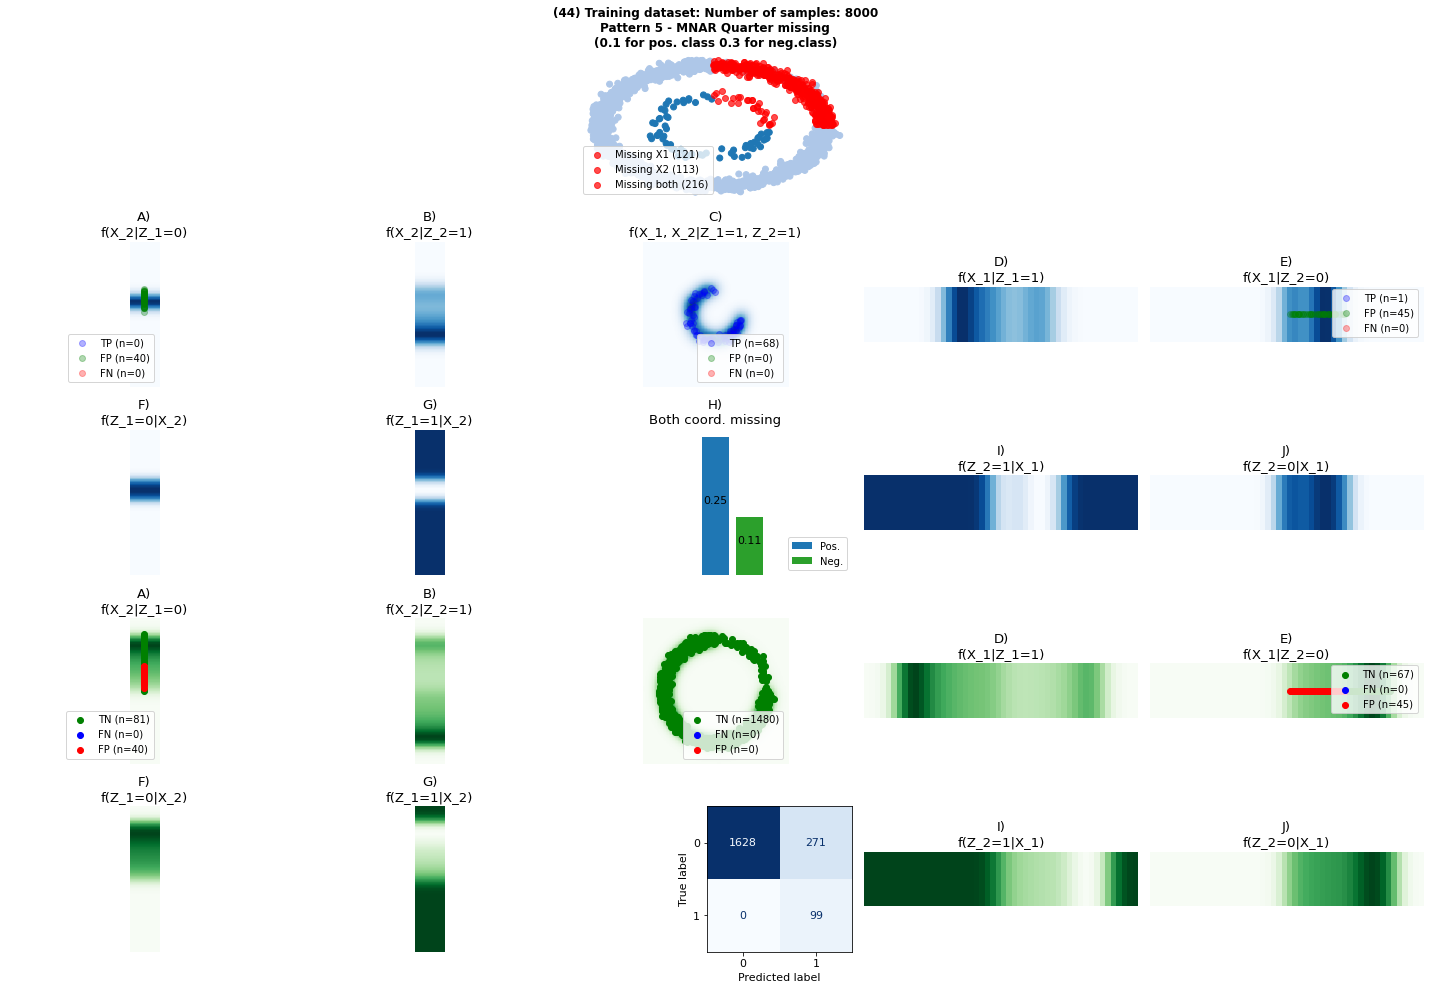

Sample: 99 positive and 1899 negative samples (#p/#n=  5%)



,0
Accuracy,0.864
F1 score (2 PPVxTPR/(PPV+TPR)),0.422
Matthews correlation coefficient (MCC),0.479
"Sensitivity, recall, hit rate, or true positive rate (TPR)",1.000
"Specificity, selectivity or true negative rate (TNR)",0.857
Precision or positive predictive value (PPV),0.268
Negative predictive value (NPV),1.000
Miss rate or false negative rate (FNR),0.000
False discovery rate (FDR=1-PPV),0.732
False omission rate (FOR=1-NPV),0.000


In [11]:
random_experiment = df[df['dataset_name']==dataset_name]['experiment_number'].sample(1).iloc[0].astype(int)
#print("Loading experiment {}".format(random_experiment))

# Create the experiments
exp = Experiments(dataset_name, 
                  dataset_train=None, 
                  dataset_test=None, 
                  purpose='classification', 
                  previous_experiment=44,#random_experiment, 
                  save_experiment=True, 
                  verbosity=1, 
                  debug=False, 
                  proportion_train=PROPORTION_TRAIN, 
                  resolution=RESOLUTION, 
                  bandwidth=BANDWIDTH,
                  random_state=RANDOM_STATE)
`
# Plot results
exp.plot()

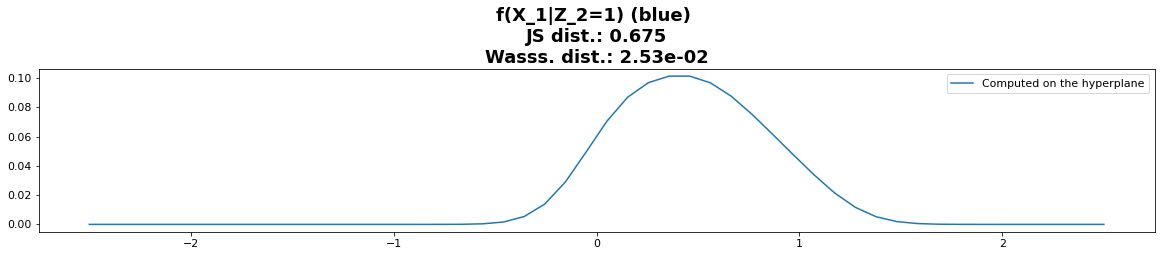

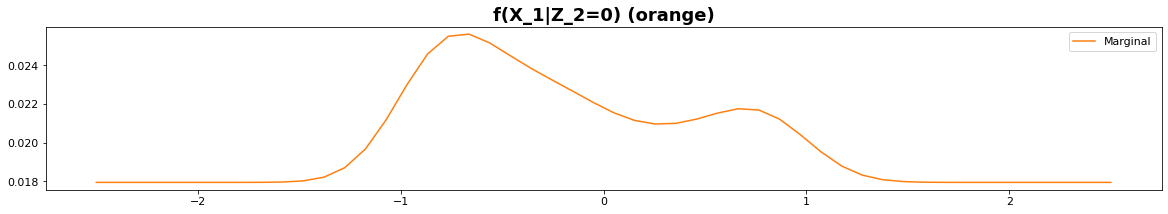

In [26]:
from scipy.spatial import distance
from scipy.stats import wasserstein_distance
fi(20, 3)
plt.plot(np.linspace(-2.5,2.5, exp.resolution), exp.dist_pos.f_1, color='tab:blue',label='Computed on the hyperplane')
plt.title("f(X_1|Z_2=1) (blue) \nJS dist.: {:.3f}\nWasss. dist.: {:.2e}".format(distance.jensenshannon(exp.dist_pos.f_1, exp.dist_pos.f_1_marginal, 2.0), wasserstein_distance(exp.dist_pos.f_1, exp.dist_pos.f_1_marginal)), weight='bold', fontsize=18)
plt.legend()

fi(20, 3)
plt.plot(np.linspace(-2.5,2.5, exp.resolution), exp.dist_pos.f_1_marginal, color='tab:orange', label='Marginal')
plt.title("f(X_1|Z_2=0) (orange)", weight='bold', fontsize=18)
plt.legend()


In [ ]:
df = create_df()

df[(df['dataset_name']==dataset_name) & (df['missingness_pattern']==5)]#['experiment_number'].sample(1).iloc[0].astype(int)

# Experiment 2) The `imputations` approach


In [ ]:
from utils import estimate_pdf

hat_f = estimate_pdf(data=X_train, method='mice', resolution=resolution, bandwidth=bandwidth)  
hat_f /= hat_f.sum()